### Import Libraries

In [1]:
!pip install -q ultralytics opencv-python-headless numpy scipy matplotlib tqdm ffmpeg-python filterpy lap

In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import csv
from scipy.stats import entropy, pearsonr, spearmanr, f_oneway, mannwhitneyu
from scipy.optimize import linear_sum_assignment
from filterpy.kalman import KalmanFilter
from tqdm import tqdm
import ffmpeg
import matplotlib.pyplot as plt
import pandas as pd

### Constants

In [3]:
VIDEO_IN = "/content/2431853-hd_1920_1080_25fps.mp4"
TEMP_OUT = "/content/temp_output.mp4"
FINAL_OUT = "/content/eco_entropy_output.mp4"
YOLO_WEIGHTS = "yolov8l.pt"

RESIZE_FACTOR = 2     # resize factor for processing (integer)
BINS = 12             # histogram bins for velocity histograms

# Tracker params
IOU_THRESH = 0.2
MAX_AGE = 15
MIN_HITS = 1

# Eco-model parameters
ALPHA = 1.0
BETA = 1.0
GAMMA = 0.0
K1 = 1.0
K2 = 0.5
K3 = 0.0

# Heatmap/grid params
GRID_W = 16
GRID_H = 9
GRID_HISTORY = 100     # how many recent velocities per grid cell to keep
VELOCITY_WINDOW = 200  # global rolling window used to compute global entropy/energy stats

## Utility: IOU

In [4]:
def iou(bb1, bb2):
    """IoU for two boxes in [x1,y1,x2,y2] format."""
    x1, y1, x2, y2 = bb1
    x1p, y1p, x2p, y2p = bb2
    xx1 = max(x1, x1p)
    yy1 = max(y1, y1p)
    xx2 = min(x2, x2p)
    yy2 = min(y2, y2p)
    w = max(0, xx2 - xx1)
    h = max(0, yy2 - yy1)
    inter = w * h
    area1 = max(0, x2 - x1) * max(0, y2 - y1)
    area2 = max(0, x2p - x1p) * max(0, y2p - y1p)
    union = area1 + area2 - inter
    return inter / union if union > 0 else 0.0

## Tracker

In [5]:
class Track:
    """Single-track state with a Kalman filter (x, y, vx, vy simplified)."""
    def __init__(self, bbox, track_id, dt=1.0):
        self.track_id = track_id
        self.bbox = np.array(bbox, dtype=float)
        # Kalman filter: state [x, y, vx, vy], measurement [x, y]
        self.kf = KalmanFilter(dim_x=4, dim_z=2)
        self.kf.F = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0],[0,1,0,0]])
        self.kf.P *= 10.0
        self.kf.R *= 1.0
        self.kf.Q *= 0.01
        cx = (bbox[0] + bbox[2]) / 2.0
        cy = (bbox[1] + bbox[3]) / 2.0
        self.kf.x = np.array([[cx], [cy], [0.0], [0.0]])
        # bookkeeping
        self.age = 0
        self.hits = 1
        self.time_since_update = 0
        self.history = []          # positions history (cx, cy)
        self.velocities = []       # list of speed magnitudes
        self.accelerations = []    # list of accelerations

    def predict(self):
        self.kf.predict()
        self.age += 1
        # store predicted position into history if it's not an immediate update
        if self.time_since_update > 0:
            self.history.append((float(self.kf.x[0,0]), float(self.kf.x[1,0])))
        return (float(self.kf.x[0,0]), float(self.kf.x[1,0]))

    def update(self, bbox):
        """Update with an observed bbox."""
        self.bbox = np.array(bbox, dtype=float)
        cx = (bbox[0] + bbox[2]) / 2.0
        cy = (bbox[1] + bbox[3]) / 2.0
        self.kf.update(np.array([cx, cy]))
        self.time_since_update = 0
        self.hits += 1
        self.history.append((float(self.kf.x[0,0]), float(self.kf.x[1,0])))

    def mark_missed(self):
        self.time_since_update += 1

class SORT:
    """Minimal SORT-like manager: match detections to tracks via Hungarian + IoU cost."""
    def __init__(self, max_age=MAX_AGE, min_hits=MIN_HITS, iou_thresh=IOU_THRESH):
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_thresh = iou_thresh
        self.tracks = []
        self.next_id = 0

    def update(self, detections):
        # Predict step for all tracks
        for t in self.tracks:
            t.predict()

        N = len(self.tracks)
        M = len(detections)

        if N > 0 and M > 0:
            cost = np.zeros((N, M), dtype=float)
            for i, tr in enumerate(self.tracks):
                for j, det in enumerate(detections):
                    cost[i, j] = 1.0 - iou(tr.bbox, det)
            row_idx, col_idx = linear_sum_assignment(cost)
            assigned_tracks = set()
            assigned_dets = set()
            for r, c in zip(row_idx, col_idx):
                if 1.0 - cost[r, c] >= self.iou_thresh:
                    self.tracks[r].update(detections[c])
                    assigned_tracks.add(r)
                    assigned_dets.add(c)
            # unassigned detections -> create new tracks
            for j, det in enumerate(detections):
                if j not in assigned_dets:
                    self.tracks.append(Track(det, self.next_id))
                    self.next_id += 1
            # unassigned tracks -> mark missed
            for i, tr in enumerate(self.tracks):
                if i not in assigned_tracks:
                    tr.mark_missed()
        else:
            # no match possible
            for det in detections:
                self.tracks.append(Track(det, self.next_id))
                self.next_id += 1
            for tr in self.tracks:
                tr.mark_missed()

        # remove old tracks
        self.tracks = [tr for tr in self.tracks if tr.time_since_update <= self.max_age]
        return self.tracks

## convert YOLO result to list of bboxe

In [6]:
def yolo_results_to_bboxes(results):
    """Convert ultralytics YOLO results to list of [x1,y1,x2,y2]."""
    if results is None or len(results) == 0:
        return []
    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        return []
    xyxy = boxes.xyxy.cpu().numpy()
    bboxes = []
    for row in xyxy:
        x1, y1, x2, y2 = float(row[0]), float(row[1]), float(row[2]), float(row[3])
        bboxes.append([x1, y1, x2, y2])
    return bboxes

## Grid heatmap for per-cell velocities

In [7]:
class GridHeatmap:
    def __init__(self, frame_w, frame_h, gw=GRID_W, gh=GRID_H, hist_len=GRID_HISTORY, bins=BINS):
        self.frame_w = frame_w
        self.frame_h = frame_h
        self.gw = gw
        self.gh = gh
        self.cell_w = frame_w / float(gw)
        self.cell_h = frame_h / float(gh)
        self.hist_len = hist_len
        self.bins = bins
        self.cell_vels = [[[] for _ in range(gw)] for __ in range(gh)]

    def add_point(self, x, y, v):
        """Add velocity `v` to the appropriate grid cell for point (x, y)."""
        cx = int(min(self.gw - 1, max(0, int(x // self.cell_w))))
        cy = int(min(self.gh - 1, max(0, int(y // self.cell_h))))
        lst = self.cell_vels[cy][cx]
        lst.append(v)
        # keep last hist_len
        if len(lst) > self.hist_len:
            del lst[:len(lst) - self.hist_len]

    def cell_entropy_map(self):
        """Return (gh, gw) array with entropy per cell computed from its velocity histogram."""
        heat = np.zeros((self.gh, self.gw), dtype=float)
        for r in range(self.gh):
            for c in range(self.gw):
                vals = np.array(self.cell_vels[r][c])
                if len(vals) >= 3:
                    hist, _ = np.histogram(vals, bins=self.bins, density=True)
                    heat[r, c] = entropy(hist + 1e-12)
                else:
                    heat[r, c] = 0.0
        return heat

## Eco model helpers

In [8]:
def compute_efficiency(S, alpha=ALPHA, beta=BETA, gamma=GAMMA):
    """Efficiency model: alpha * exp(-beta * S) + gamma"""
    return float(alpha * np.exp(-beta * S) + gamma)

def compute_CO2(sigma_v2, S, k1=K1, k2=K2, k3=K3):
    """CO2 estimate model: k1 * sigma_v2 + k2 * S + k3"""
    return float(k1 * sigma_v2 + k2 * S + k3)

### **Main Processing loop**


In [9]:
def process_video(video_in=VIDEO_IN,
                  yolo_weights=YOLO_WEIGHTS,
                  temp_out=TEMP_OUT,
                  final_out=FINAL_OUT,
                  resize_factor=RESIZE_FACTOR,
                  bins=BINS,
                  save_csv=True):
    """
    Process the video and produce:
      - final H.264 encoded video (final_out)
      - CSV with per-frame metrics (frame_metrics.csv)
      - returned dict with rows and correlation stats
    """
    print("Loading YOLO model:", yolo_weights)
    model = YOLO(yolo_weights)

    cap = cv2.VideoCapture(video_in)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {video_in}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = orig_w // resize_factor
    h = orig_h // resize_factor

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(temp_out, fourcc, fps, (w, h))

    tracker = SORT()
    grid = GridHeatmap(w, h, gw=GRID_W, gh=GRID_H, hist_len=GRID_HISTORY, bins=bins)

    all_recent_velocities = []
    rows = []
    frame_id = 0

    print(f"Processing {total_frames} frames (resized to {w}x{h}) ...")
    for _ in tqdm(range(total_frames), desc="Frames"):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (w, h))

        # Detection
        results = model(frame, verbose=False)
        detections = yolo_results_to_bboxes(results)

        # Visualize raw detections (light rectangle)
        for det in detections:
            x1,y1,x2,y2 = [int(v) for v in det]
            cv2.rectangle(frame, (x1,y1), (x2,y2), (60,60,60), 1)

        # Tracking
        tracks = tracker.update(detections)
        frame_velocities = []

        # For each track, compute instantaneous velocity (if history present), visualize bbox + ID + arrow
        for tr in tracks:
            cx = float(tr.kf.x[0,0])
            cy = float(tr.kf.x[1,0])
            if len(tr.history) >= 2:
                px, py = tr.history[-2]
                vx = cx - px
                vy = cy - py
                speed = np.sqrt(vx*vx + vy*vy)
                tr.velocities.append(speed)
                frame_velocities.append(speed)
                all_recent_velocities.append(speed)
                # add to grid
                grid.add_point(cx, cy, speed)
                # acceleration
                if len(tr.velocities) >= 2:
                    acc = tr.velocities[-1] - tr.velocities[-2]
                    tr.accelerations.append(acc)

            bx1, by1, bx2, by2 = [int(v) for v in tr.bbox]
            cv2.rectangle(frame, (bx1,by1), (bx2,by2), (16,200,16), 2)
            cv2.putText(frame, f"ID:{tr.track_id}", (int(cx), int(cy)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
            if len(tr.history) >= 1:
                px, py = tr.history[-1]
                cv2.arrowedLine(frame, (int(px), int(py)), (int(cx), int(cy)), (255,200,0), 1, tipLength=0.3)

        # truncate global velocity window
        if len(all_recent_velocities) > VELOCITY_WINDOW:
            all_recent_velocities = all_recent_velocities[-VELOCITY_WINDOW:]

        # global entropy S (from histogram of recent velocities)
        if len(all_recent_velocities) >= 5:
            hist, _ = np.histogram(all_recent_velocities, bins=bins, density=True)
            S = float(entropy(hist + 1e-12))
        else:
            S = 0.0

        # sigma_E2 (variance of per-object kinetic energy E = 0.5 * v^2)
        if len(all_recent_velocities) >= 5:
            E = 0.5 * np.array(all_recent_velocities)**2
            sigma_E2 = float(np.var(E))
        else:
            sigma_E2 = 0.0

        efficiency = compute_efficiency(S)
        E_co2 = compute_CO2(sigma_E2, S)

        # overlay numbers on the frame
        cv2.putText(frame, f"Entropy: {S:.4f}", (10, 26), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,165,255), 2, cv2.LINE_AA)
        cv2.putText(frame, f"sigma_E2: {sigma_E2:.4f}", (10, 54), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,200), 2, cv2.LINE_AA)
        cv2.putText(frame, f"Eff: {efficiency:.4f}", (10, 78), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,200,50), 2, cv2.LINE_AA)
        cv2.putText(frame, f"CO2: {E_co2:.4f}", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,50,200), 2, cv2.LINE_AA)

        out.write(frame)

        rows.append({
            'frame': frame_id,
            'entropy': S,
            'sigma_E2': sigma_E2,
            'efficiency': efficiency,
            'E_co2': E_co2,
            'n_tracks': len(tracks),
            'mean_speed_frame': float(np.mean(frame_velocities)) if len(frame_velocities)>0 else 0.0
        })

        frame_id += 1

    cap.release()
    out.release()

    # Re-encode to H.264 using ffmpeg-python for better compatibility
    print("Re-encoding to H.264 (final output)...")
    (
        ffmpeg
        .input(temp_out)
        .output(final_out, vcodec='libx264', pix_fmt='yuv420p', crf=23, loglevel="error")
        .run(overwrite_output=True)
    )

    # Save CSV
    csv_path = 'frame_metrics.csv'
    if save_csv and rows:
        keys = rows[0].keys()
        with open(csv_path, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=list(keys))
            writer.writeheader()
            writer.writerows(rows)
        print('Saved frame metrics ->', csv_path)

    # correlation stats
    ent = np.array([r['entropy'] for r in rows])
    co2 = np.array([r['E_co2'] for r in rows])
    eff = np.array([r['efficiency'] for r in rows])
    valid_mask = (~np.isnan(ent)) & (~np.isnan(co2))
    if valid_mask.sum() > 2:
        p_pearson, p_p = pearsonr(ent[valid_mask], co2[valid_mask])
        s_spearman, s_p = spearmanr(ent[valid_mask], co2[valid_mask])
    else:
        p_pearson, p_p, s_spearman, s_p = (np.nan, np.nan, np.nan, np.nan)

    print(f"Pearson(entropy,CO2) = {p_pearson:.4f} (p={p_p:.4e})")
    print(f"Spearman(entropy,CO2) = {s_spearman:.4f} (p={s_p:.4e})")

    return {
        'rows': rows,
        'pearson': (p_pearson, p_p),
        'spearman': (s_spearman, s_p),
        'final_video': final_out
    }

In [10]:
if __name__ == '__main__':
    # quick run
    res = process_video()
    print('Done. Outputs:', res['final_video'])

Loading YOLO model: yolov8l.pt
Processing 1513 frames (resized to 960x540) ...


Frames: 100%|██████████| 1513/1513 [00:58<00:00, 25.88it/s]


Re-encoding to H.264 (final output)...
Saved frame metrics -> frame_metrics.csv
Pearson(entropy,CO2) = -0.0151 (p=5.5788e-01)
Spearman(entropy,CO2) = -0.0407 (p=1.1380e-01)
Done. Outputs: /content/eco_entropy_output.mp4


## VISUALIZATION SUITE

Text(0.5, 1.0, 'Entropy Over Time')

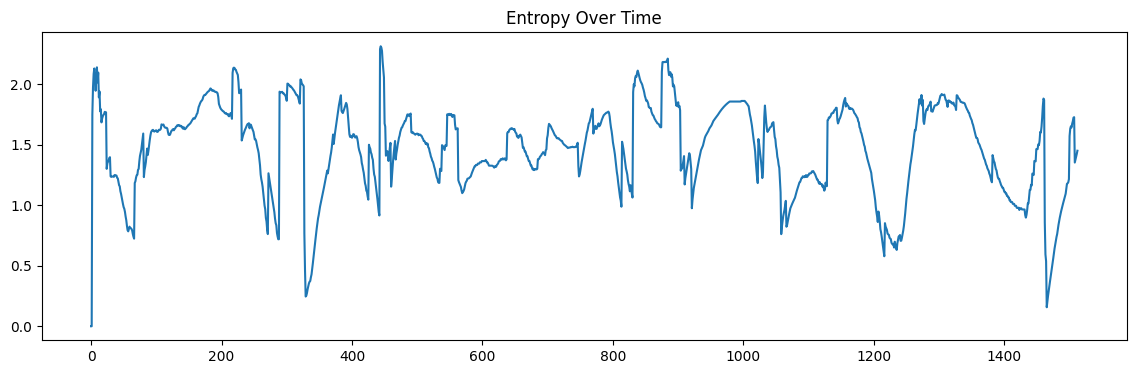

In [11]:
import pandas as pd

df = pd.read_csv("frame_metrics.csv")
df.index.name = "frame"

plt.figure(figsize=(14,4))
plt.plot(df.index, df["entropy"])
plt.title("Entropy Over Time")

Text(0.5, 1.0, 'σᵥ² (Motion Variance) Over Time')

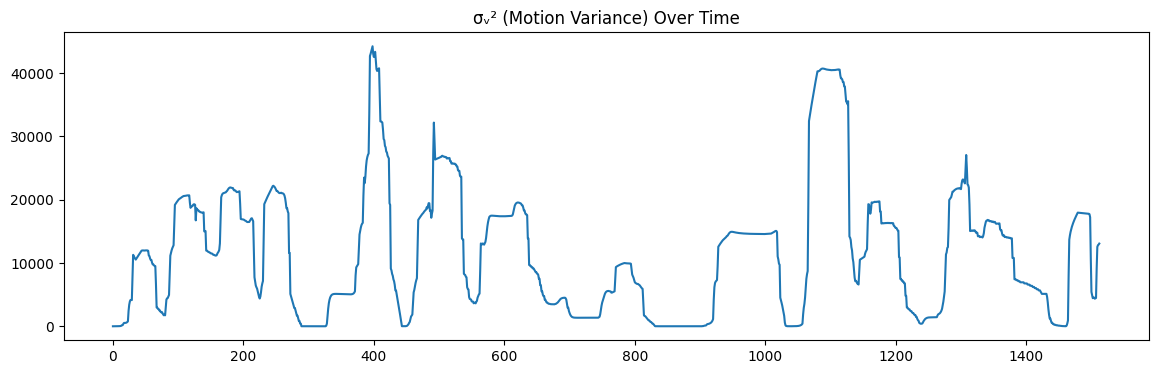

In [12]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["sigma_E2"])
plt.title("σᵥ² (Motion Variance) Over Time")

Text(0.5, 1.0, 'Efficiency Over Time')

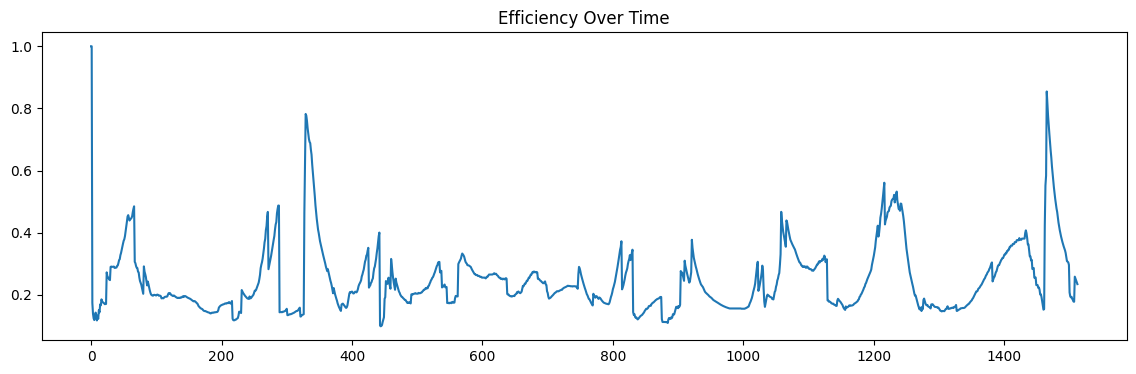

In [13]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["efficiency"])
plt.title("Efficiency Over Time")

Text(0.5, 1.0, 'CO₂ Estimate Over Time')

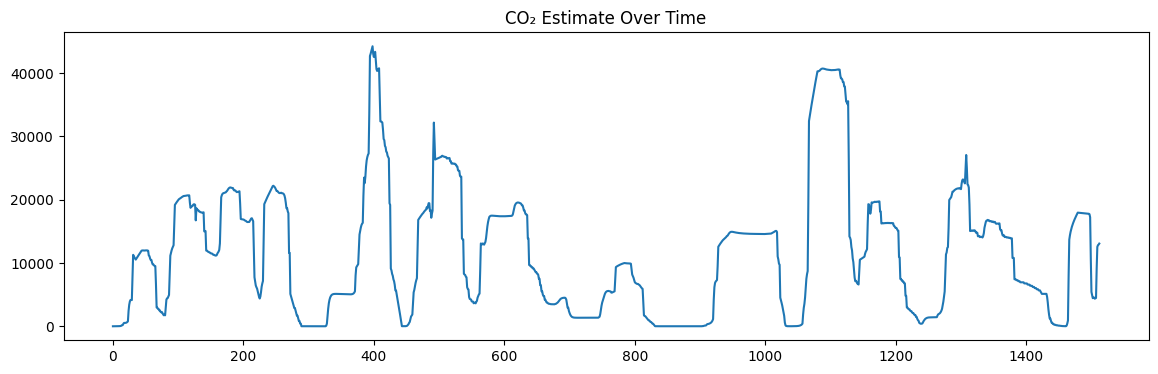

In [14]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["E_co2"])
plt.title("CO₂ Estimate Over Time")

In [21]:
n_segments = 2

# Segment boundaries
total_frames = len(df)
size = total_frames // n_segments
segs = [(i*size, (i+1)*size if i < n_segments-1 else total_frames)
        for i in range(n_segments)]

# Extract segment groups
entropy_groups = [df["entropy"].iloc[s:e] for s, e in segs]
co2_groups     = [df["E_co2"].iloc[s:e] for s, e in segs]

# ANOVA
print("=== ANOVA RESULTS ===")
print("Entropy:", f_oneway(*entropy_groups))
print("CO₂:",     f_oneway(*co2_groups))

# Mann-Whitney
print("\n=== Mann-Whitney Tests ===")
for i in range(n_segments):
    for j in range(i+1, n_segments):
        mw_e = mannwhitneyu(entropy_groups[i], entropy_groups[j])
        mw_c = mannwhitneyu(co2_groups[i], co2_groups[j])
        print(f"{i} vs {j}: Entropy p={mw_e.pvalue:.4f}, CO₂ p={mw_c.pvalue:.4f}")

=== ANOVA RESULTS ===
Entropy: F_onewayResult(statistic=np.float64(2.4888798487942343), pvalue=np.float64(0.11486261851683009))
CO₂: F_onewayResult(statistic=np.float64(2.0452168279903193), pvalue=np.float64(0.15289196801932672))

=== Mann-Whitney Tests ===
0 vs 1: Entropy p=0.6577, CO₂ p=0.0003
